In [1]:
import sys
sys.path.append(".")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
from Models import UnivariateLinearModel
from Datasets import CustomTensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
%reload_ext autoreload
%autoreload 2

# Pytorch' NN

## Linear regression with one variable 

In [3]:
data = np.loadtxt('ex1data1.txt', delimiter=',')
X, Y = data[:,0], data[:,1]

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(data[:,0], data[:,1], test_size = 0.2)

Datasets

In [5]:
train_ds = CustomTensorDataset(features=X_train, y=Y_train)
test_ds = CustomTensorDataset(features=X_test, y=Y_test)

In [6]:
for i in range(5):
    x, y = train_ds[i]
    print(f'X: {x}, Y: {y}')

X: tensor([-0.7121], dtype=torch.float64), Y: tensor([4.2630], dtype=torch.float64)
X: tensor([-0.2829], dtype=torch.float64), Y: tensor([5.3893], dtype=torch.float64)
X: tensor([-0.4851], dtype=torch.float64), Y: tensor([5.1875], dtype=torch.float64)
X: tensor([0.0734], dtype=torch.float64), Y: tensor([11.8860], dtype=torch.float64)
X: tensor([-0.6805], dtype=torch.float64), Y: tensor([3.3928], dtype=torch.float64)


Dataloders

In [7]:
train_dl = DataLoader(train_ds, batch_size=len(train_ds))
test_dl = DataLoader(test_ds, batch_size=len(test_ds))

### Plotting de data

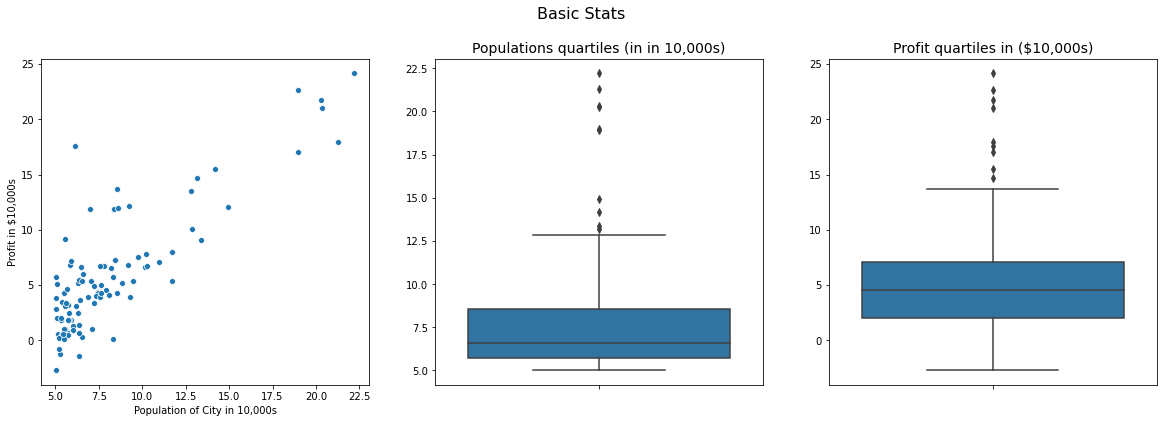

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Basic Stats', fontsize=16, y=1)

sns.scatterplot(x=X, y=Y, ax=ax1)
ax1.set_xlabel('Population of City in 10,000s')
ax1.set_ylabel('Profit in $10,000s')

sns.boxplot(y=X, ax=ax2)
ax2.set_title('Populations quartiles (in in 10,000s)', fontsize=14)

sns.boxplot(y=Y, ax=ax3)
ax3.set_title('Profit quartiles in ($10,000s)', fontsize=14)

plt.show()

### NN Model Class

In [9]:
torch.set_default_dtype(torch.double)

In [10]:
hidden_size = 6

### Training the net

In [11]:
model = UnivariateLinearModel(1, hidden_size, 1)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss(reduction='mean')

In [12]:
model

UnivariateLinearModel(
  (layer): Sequential(
    (0): Linear(in_features=1, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [13]:
epochs = 1000
losses = []
for i in tqdm(range(epochs)):
    for x, y in train_dl:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [14]:
x_train, y_train = train_ds.get_dataset()

In [15]:
x_test, y_test = test_ds.get_dataset()

### Validating the net

In [16]:
with torch.no_grad():
    y_train_pred = model(x_train)
    y_test_pred = model(x_test)

In [17]:
#y_train_pred = np.squeeze(y_train_pred.detach().numpy())
score_train = r2_score(y_train, y_train_pred)
print(f'Score in training: {score_train}')

Score in training: 0.718277933995193


In [18]:
score_test = r2_score(y_test, y_test_pred)
print(f'Score in testing: {score_test}')

Score in training: 0.5903912819080355


In [19]:
y_train_pred = y_train_pred.detach().numpy().squeeze()
y_test_pred = y_test_pred.detach().numpy().squeeze()

x_train, y_train = train_ds.reverse_transform()
x_test, y_test = test_ds.reverse_transform()

### Plotting results

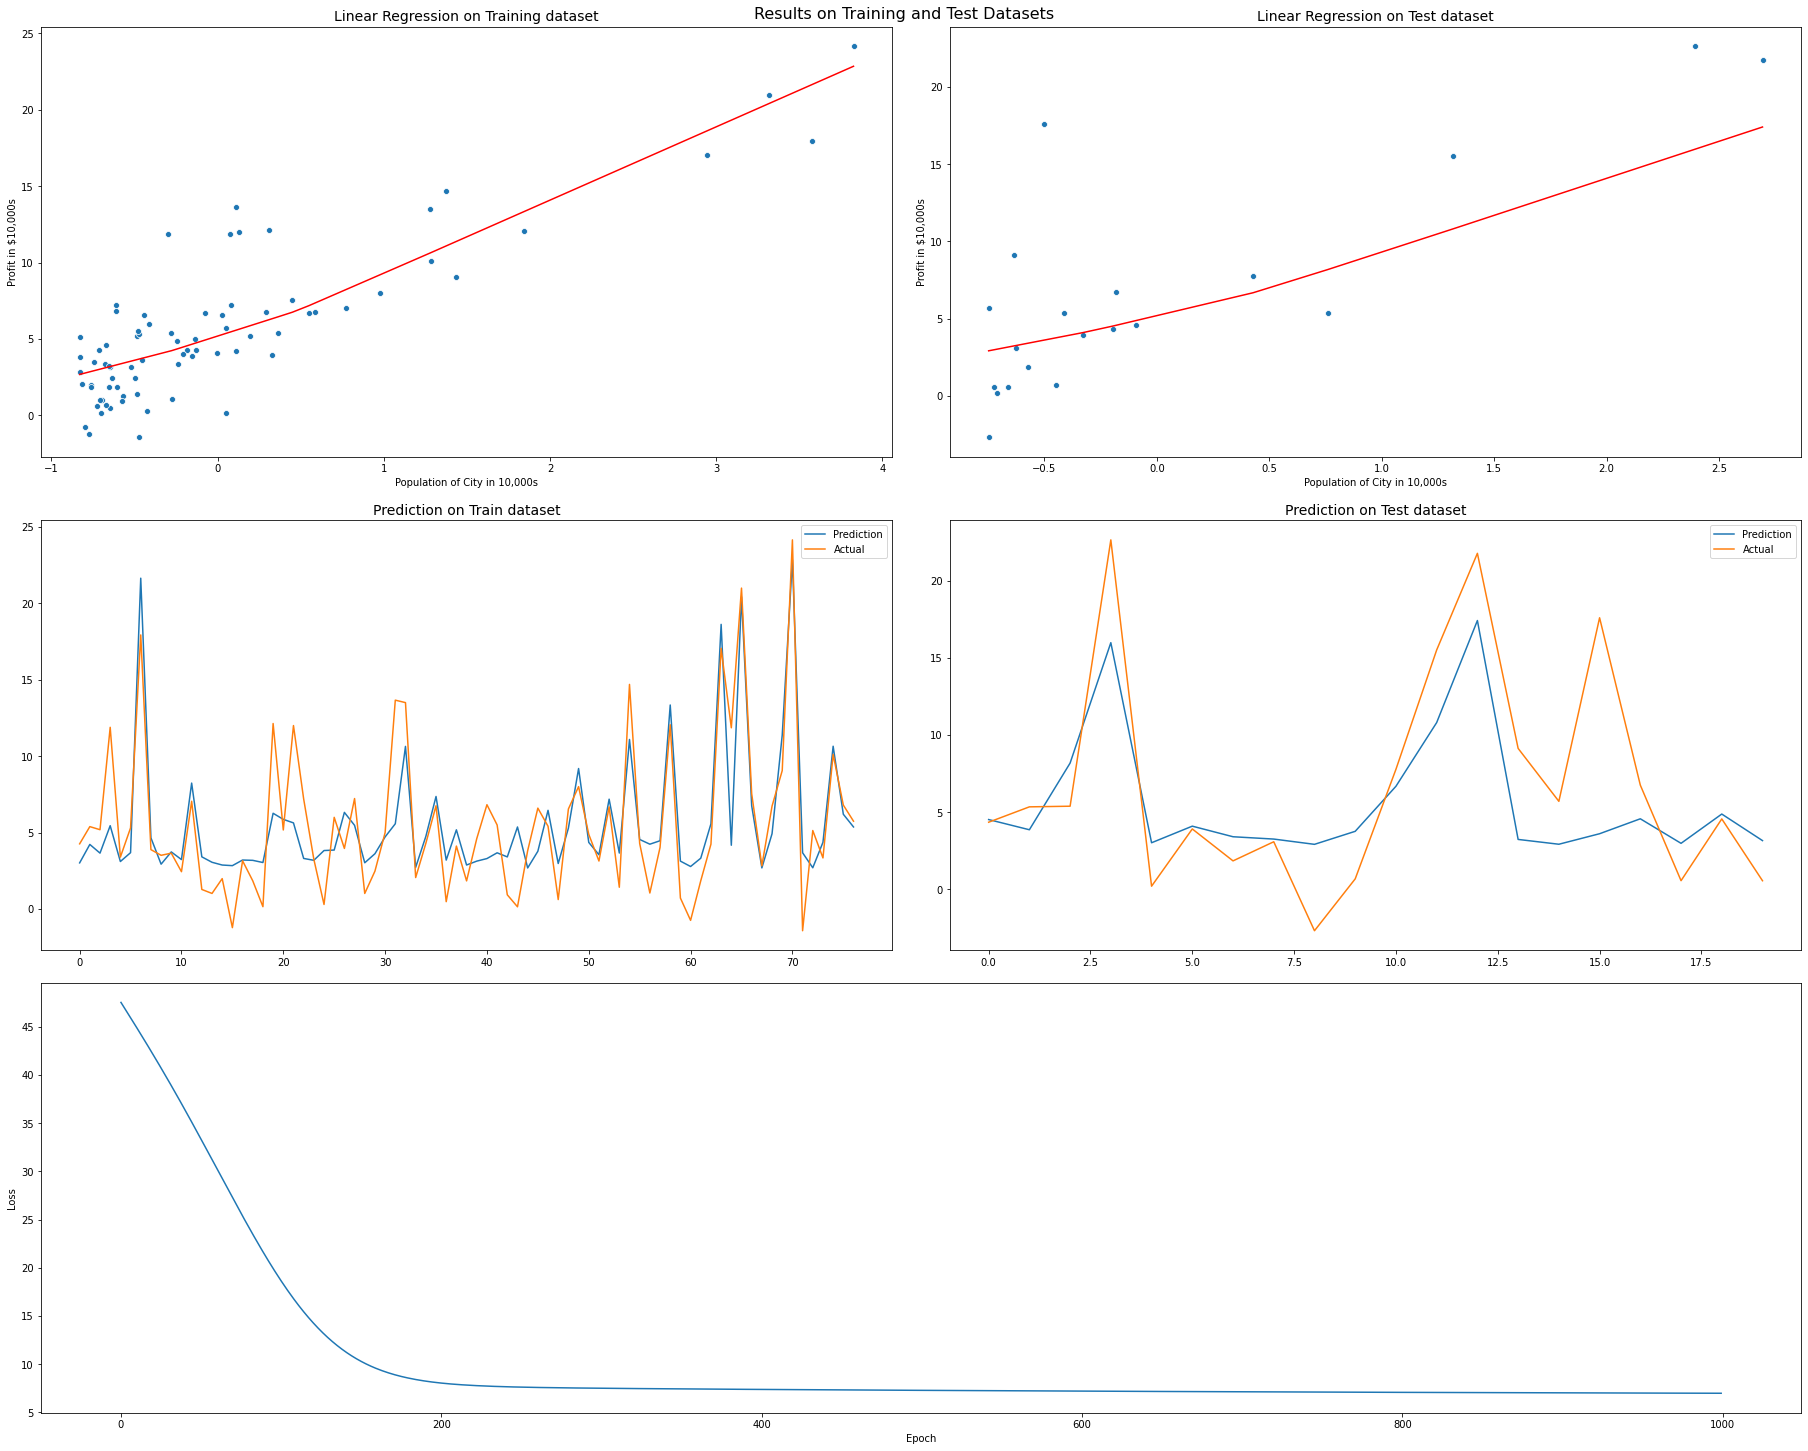

In [20]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(25, 15))
fig = plt.figure(constrained_layout=True, figsize=(25, 20))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, :])

fig.suptitle('Results on Training and Test Datasets', fontsize=16, y=1)

ax1.set_title('Linear Regression on Training dataset', fontsize=14)
sns.scatterplot(x=x_train, y=y_train, ax=ax1)
ax1.set_xlabel('Population of City in 10,000s')
ax1.set_ylabel('Profit in $10,000s')
sns.lineplot(x_train, y_train_pred, color='red', ax=ax1)

ax2.set_title('Linear Regression on Test dataset', fontsize=14)
sns.scatterplot(x=x_test, y=y_test, ax=ax2)
ax2.set_xlabel('Population of City in 10,000s')
ax2.set_ylabel('Profit in $10,000s')
sns.lineplot(x_test, y_test_pred, color='red', ax=ax2)

sns.lineplot(y=y_train_pred, x=range(len(y_train_pred)), ax=ax3, label='Prediction')
sns.lineplot(y=y_train, x=range(len(y_train)), ax=ax3, label='Actual')
ax3.set_title('Prediction on Train dataset', fontsize=14)

sns.lineplot(y=y_test_pred, x=range(len(y_test_pred)), ax=ax4, label='Prediction')
sns.lineplot(y=y_test, x=range(len(y_test)), ax=ax4, label='Actual')
ax4.set_title('Prediction on Test dataset', fontsize=14)

sns.lineplot(y=losses, x=range(len(losses)), ax=ax5)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')

plt.show()